# Autoencoder Implementation

### 1. Purpose

This notebook implements an autoencoder-based Intrusion Detection System (IDS) using the preprocessed dataset produced in 01_dataset_preprocessing.ipynb. The autoencoder is trained only on benign traffic and uses reconstruction error as an anomaly score.

### 2. Imports

In [2]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

### 3. Load Processed Dataset

In [3]:
X_train = pd.read_csv("processed/X_train.csv").values
X_val = pd.read_csv("processed/X_val.csv").values
X_test = pd.read_csv("processed/X_test.csv").values

y_train = pd.read_csv("processed/y_train.csv").values.ravel()
y_val = pd.read_csv("processed/y_val.csv").values.ravel()
y_test = pd.read_csv("processed/y_test.csv").values.ravel()

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (1979513, 77)
Validation shape: (424181, 77)
Test shape: (424182, 77)


### 4. Select Benign Training Data

The autoencoder is trained only on benign traffic (label = 0).

In [4]:
X_train_benign = X_train[y_train == 0]

print("Benign training samples:", X_train_benign.shape[0])

Benign training samples: 1589924


### 5. Convert to PyTorch Tensors

In [5]:
X_train_tensor = torch.tensor(X_train_benign, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

In [6]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

input_dim = X_train_tensor.shape[1]
model = AutoEncoder(input_dim)

### 7. Training Setup

In [7]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_loader = DataLoader(
    TensorDataset(X_train_tensor),
    batch_size=256,
    shuffle=True
)

### 8. Train Autoencoder

Epoch 1/30 | Loss: 0.198619
Epoch 2/30 | Loss: 0.116473
Epoch 3/30 | Loss: 0.108319
Epoch 4/30 | Loss: 0.090635
Epoch 5/30 | Loss: 0.086814
Epoch 6/30 | Loss: 0.080453
Epoch 7/30 | Loss: 0.076218
Epoch 8/30 | Loss: 0.085134
Epoch 9/30 | Loss: 0.084799
Epoch 10/30 | Loss: 0.065797
Epoch 11/30 | Loss: 0.075813
Epoch 12/30 | Loss: 0.116535
Epoch 13/30 | Loss: 0.093991
Epoch 14/30 | Loss: 0.049674
Epoch 15/30 | Loss: 0.086780
Epoch 16/30 | Loss: 0.067949
Epoch 17/30 | Loss: 0.113619
Epoch 18/30 | Loss: 0.071846
Epoch 19/30 | Loss: 0.054487
Epoch 20/30 | Loss: 0.092675
Epoch 21/30 | Loss: 0.068283
Epoch 22/30 | Loss: 0.063683
Epoch 23/30 | Loss: 0.051551
Epoch 24/30 | Loss: 0.466122
Epoch 25/30 | Loss: 0.053546
Epoch 26/30 | Loss: 0.087769
Epoch 27/30 | Loss: 0.055208
Epoch 28/30 | Loss: 0.069783
Epoch 29/30 | Loss: 0.043286
Epoch 30/30 | Loss: 0.079826


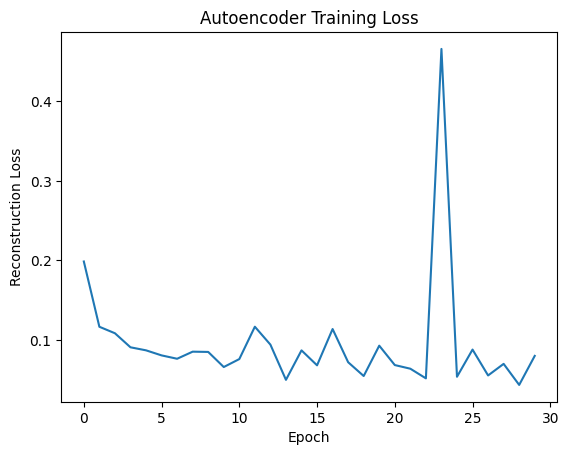

In [8]:
EPOCHS = 30
losses = []

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    for (x_batch,) in train_loader:
        optimizer.zero_grad()
        x_hat = model(x_batch)
        loss = criterion(x_hat, x_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {epoch_loss:.6f}")

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss")
plt.title("Autoencoder Training Loss")
plt.show()

### 9. Reconstruction Error (Anomaly Score)

In [9]:
model.eval()

with torch.no_grad():
    recon_val = model(X_val_tensor)
    recon_test = model(X_test_tensor)

    val_mse = torch.mean((X_val_tensor - recon_val) ** 2, dim=1).numpy()
    test_mse = torch.mean((X_test_tensor - recon_test) ** 2, dim=1).numpy()

### 10. Threshold Selection (Validation Set)

Threshold is selected using benign validation samples only.

In [10]:
threshold = np.percentile(val_mse[y_val == 0], 95)

print("Selected threshold:", threshold)

Selected threshold: 0.011326235


### 11. Evaluation on Test Set

              precision    recall  f1-score   support

           0     0.8770    0.9501    0.9121    340698
           1     0.6912    0.4561    0.5496     83484

    accuracy                         0.8529    424182
   macro avg     0.7841    0.7031    0.7308    424182
weighted avg     0.8404    0.8529    0.8407    424182



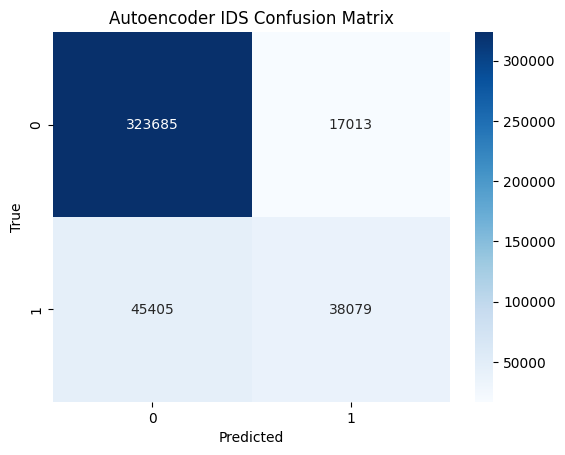

In [11]:
y_pred = (test_mse > threshold).astype(int)

print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Autoencoder IDS Confusion Matrix")
plt.show()

### 12. Reconstruction Error Distribution

In [ ]:
plt.figure(figsize=(7,4))
sns.histplot(test_mse[y_test == 0], bins=50, label="Benign", stat="density")
sns.histplot(test_mse[y_test == 1], bins=50, label="Attack", stat="density")
plt.legend()
plt.title("Reconstruction Error Distribution (Test Set)")
plt.show()

### 13. Notes for Report

- The autoencoder is trained exclusively on benign traffic.
- Reconstruction error is used as anomaly score.
- Threshold is chosen on validation data to avoid test leakage.
- Results illustrate the trade-off between recall and false positives typical of anomaly-based IDS.